## Bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


## Download e Preparação do Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = CIFAR10(root='data/', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='data/', train=False, transform=transform, download=True)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


In [ ]:
train_size = 40000
val_size = 10000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
for images, labels in val_loader:
    print(images.shape, labels.shape)
    break


torch.Size([32, 3, 32, 32]) torch.Size([32])


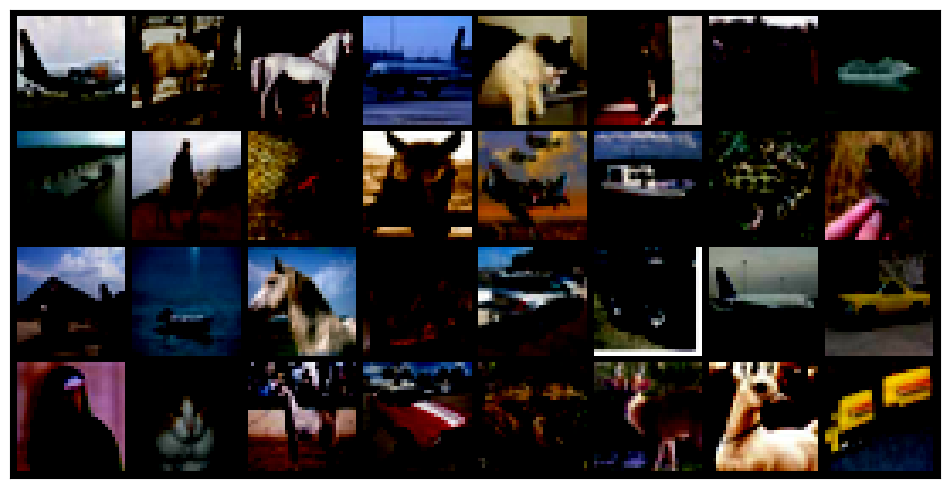

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        plt.show()
        break

show_batch(train_loader)

## Modelo

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():  # sem cálculo de gradiente na val
            out = self(images)
            loss = F.cross_entropy(out, labels)
            acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], train_loss: {result['train_loss']:.4f}, "
              f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [ ]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32x32 -> 16x16
            nn.Dropout(0.25),


            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 16x16 -> 8x8
            nn.Dropout(0.25),


            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 8x8 -> 4x4
            nn.Dropout(0.4),


            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, xb):
        return self.network(xb)

## Treinamento

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer =   opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        count = 0

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            count += 1

        result = evaluate(model, val_loader)
        result['train_loss'] = train_loss / count
        model.epoch_end(epoch, result)
        history.append(result)

        import gc
        gc.collect()
        torch.cuda.empty_cache()

    return history


In [ ]:
model = CIFAR10Model()

In [ ]:
model = model.to(device)

In [ ]:
import torch.optim as optim

num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001


history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [1], train_loss: 1.5969, val_loss: 1.4857, val_acc: 0.5011
Epoch [2], train_loss: 1.2433, val_loss: 0.9375, val_acc: 0.6633
Epoch [3], train_loss: 1.0787, val_loss: 0.9857, val_acc: 0.6500
Epoch [4], train_loss: 0.9814, val_loss: 0.8046, val_acc: 0.7141
Epoch [5], train_loss: 0.9083, val_loss: 0.7490, val_acc: 0.7295
Epoch [6], train_loss: 0.8505, val_loss: 0.6712, val_acc: 0.7617
Epoch [7], train_loss: 0.7998, val_loss: 0.6402, val_acc: 0.7749
Epoch [8], train_loss: 0.7406, val_loss: 0.6202, val_acc: 0.7842
Epoch [9], train_loss: 0.7098, val_loss: 0.5955, val_acc: 0.7931
Epoch [10], train_loss: 0.6696, val_loss: 0.5476, val_acc: 0.8105
Epoch [11], train_loss: 0.6329, val_loss: 0.6468, val_acc: 0.7846
Epoch [12], train_loss: 0.6026, val_loss: 0.5322, val_acc: 0.8133
Epoch [13], train_loss: 0.5718, val_loss: 0.5383, val_acc: 0.8222
Epoch [14], train_loss: 0.5567, val_loss: 0.4995, val_acc: 0.8314
Epoch [15], train_loss: 0.5287, val_loss: 0.4943, val_acc: 0.8315
Epoch [16], train_l

## Avaliação dos Resultados

In [ ]:
def plot_accuracies(history):
    """ Plot the history of validation accuracies """
    accuracies = [x['val_acc'] for x in history]
    plt.figure(figsize=(8,5))
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.grid(True)
    plt.show()


def plot_losses(history):
    """ Plot training and validation losses """
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, '-bx', label='Training Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

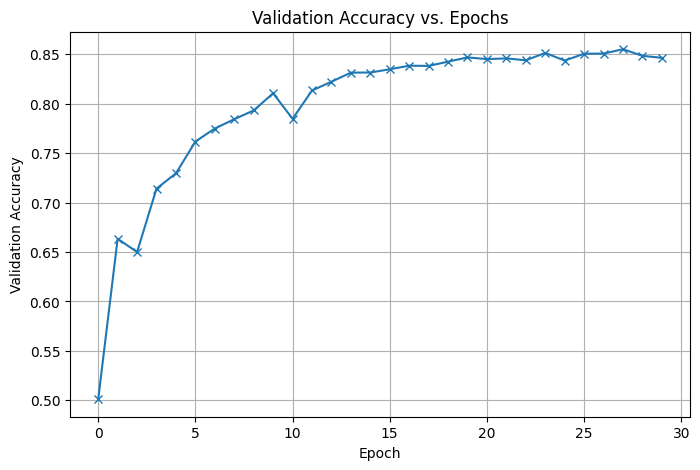

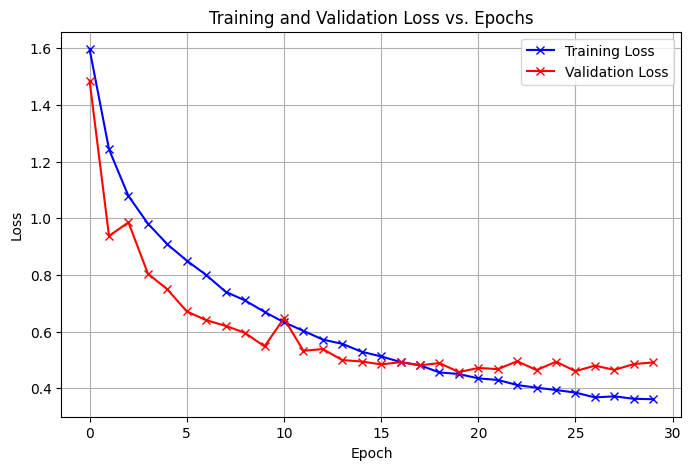

In [ ]:
plot_accuracies(history)
plot_losses(history)

In [ ]:
model.eval()

test_result = evaluate(model, test_loader)
print(f"Test Loss: {test_result['val_loss']:.4f}, Test Accuracy: {test_result['val_acc']:.4f}")

Test Loss: 0.5121, Test Accuracy: 0.8409


In [ ]:
classes = test_dataset.classes

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

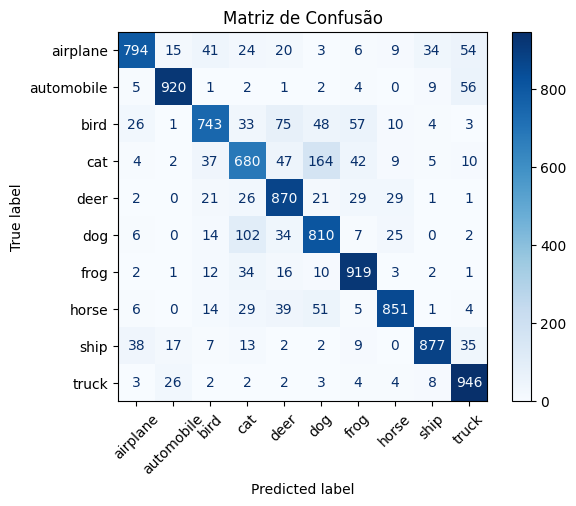

In [ ]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.90      0.79      0.84      1000
  automobile       0.94      0.92      0.93      1000
        bird       0.83      0.74      0.79      1000
         cat       0.72      0.68      0.70      1000
        deer       0.79      0.87      0.83      1000
         dog       0.73      0.81      0.77      1000
        frog       0.85      0.92      0.88      1000
       horse       0.91      0.85      0.88      1000
        ship       0.93      0.88      0.90      1000
       truck       0.85      0.95      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [ ]:
def imshow_grid(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.cpu().numpy()
    return np.transpose(npimg, (1, 2, 0))

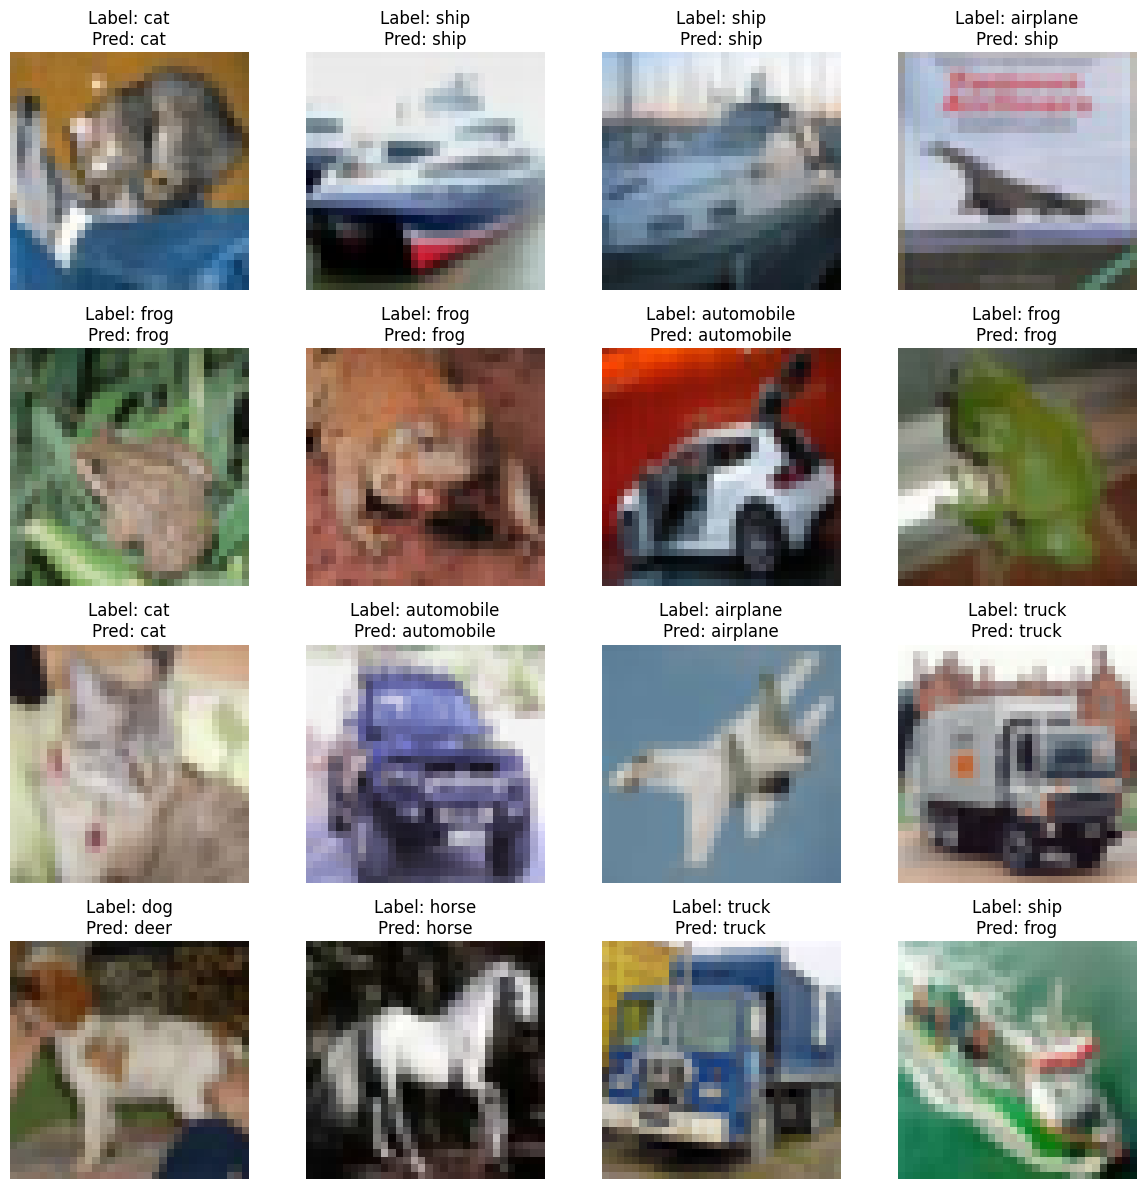

In [ ]:
num_images = 16
plt.figure(figsize=(12,12))

for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(imshow_grid(images[i]))
    plt.title(f"Label: {classes[labels[i].item()]}\nPred: {classes[preds[i].item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()